# Setup
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

from regex import regex
from preprocess import preprocess_all
from util import read_bills, read_stopwords, split_ttf
from variants import variant_i, variant_ii, variant_iii, variant_iv

In [3]:
warnings.filterwarnings('ignore')

In [4]:
bills = read_bills('../lab1/data')

In [5]:
df = preprocess_all(bills)

Could not resolve header for 1996_400.txt


In [6]:
df['is_amendment'].describe()

count     1178
unique       2
top       True
freq       610
Name: is_amendment, dtype: object

In [7]:
train, test, validation = split_ttf(df)

In [8]:
print('train      {}'.format(len(train)))
print('test       {}'.format(len(test)))
print('validation {}'.format(len(validation)))

train      706
test       236
validation 236


# SVM + TF-IDF
---

## Analysis

In [92]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from preprocess import extract_tokens
from util import build_vocabulary
from svm import teach_svm, evaluate
from vis import plot_metrics_for

In [15]:
stopwords = read_stopwords('./stopwords-pl.txt')

In [27]:
vocabulary = build_vocabulary(df, drop_threshold=1000, drop_exceptions=['"ust.', '"art.'])

In [16]:
train.describe()

,bill_file,text,is_amendment
count,706,706,706
unique,706,706,2
top,1997_684.txt,Art. 1.\n\nW ustawie z dnia 4 marca 1994 r. o ...,True
freq,1,1,364


In [23]:
clf, metrics = teach_svm(train, validation, df, stopwords)

Score 0.7288135593220338 for tol=1e-11, c=0.1, kernel=linear, drop=0
Score 0.8008474576271186 for tol=1e-11, c=1, kernel=linear, drop=0
Score 0.809322033898305 for tol=1, c=100, kernel=linear, drop=0
Score 0.8177966101694916 for tol=1e-11, c=1, kernel=linear, drop=1000
Score 0.8347457627118644 for tol=1e-11, c=100, kernel=rbf, drop=1000


In [28]:
evaluate(test, clf, vocabulary, stopwords)

0.8601694915254238

In [33]:
def predict(clf, df):
    vectorizer = TfidfVectorizer(vocabulary=vocabulary, stop_words=stopwords)
    X = vectorizer.fit_transform(df['text'])
    return clf.predict(X)

In [43]:
def show_scores(clf, df):
    p, r, f1, _ = precision_recall_fscore_support(
        df['is_amendment'], predict(clf, df), average='weighted')
    
    print('Precision: {0}'.format(p))
    print('Recall:    {0}'.format(r))
    print('F1 score:  {0}'.format(f1))

In [44]:
show_scores(clf, test)

Precision: 0.8614231180332875
Recall:    0.8601694915254238
F1 score:  0.8604095547459006


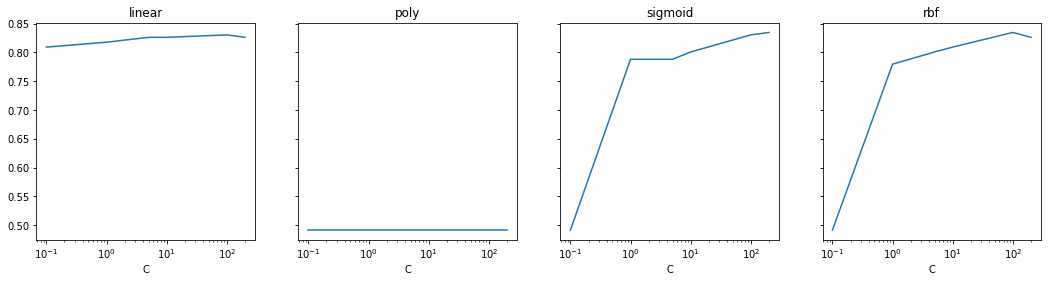

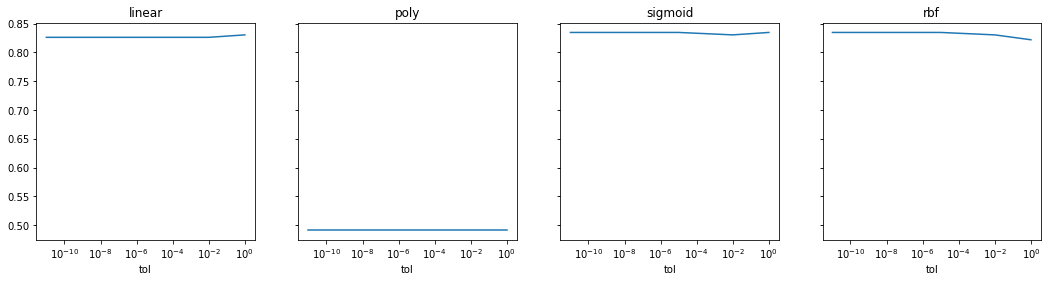

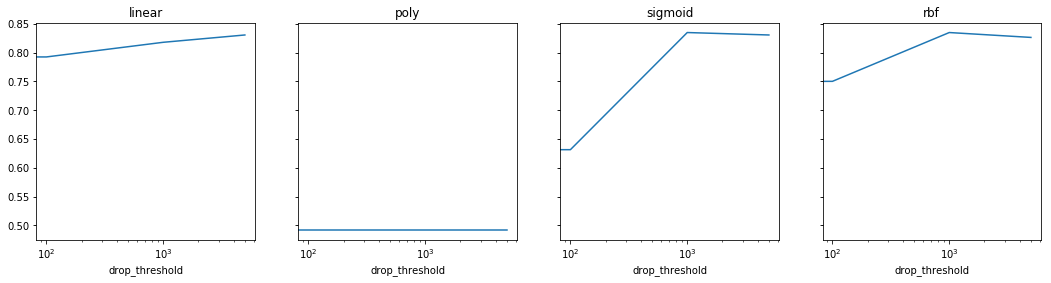

In [100]:
plot_metrics_for('C', metrics)
plot_metrics_for('tol', metrics)
plot_metrics_for('drop_threshold', metrics)

## Results

In [131]:
from variants import *

# Fasttext
---

In [144]:
from fastText import FastText
from fasttext import prepare_files

In [145]:
ft = df.copy()

In [ ]:
model = fastText.train_supervised("data.bak/train.csv",lr=0.7,epoch = 20)

# Flair 
---